In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

In [10]:
PROJECT_ROOT = os.path.abspath("..")
PROCESSED_PATH = os.path.join(PROJECT_ROOT, "data", "processed")
MODELS_PATH = os.path.join(PROJECT_ROOT, "models")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_path = os.path.join(PROCESSED_PATH, "X_train.npy")
y_train_path = os.path.join(PROCESSED_PATH, "y_train.npy")
X_val_path = os.path.join(PROCESSED_PATH, "X_val.npy")
y_val_path = os.path.join(PROCESSED_PATH, "y_val.npy")

In [11]:
X_train = np.load(X_train_path).astype(np.float32)
y_train = np.load(y_train_path).astype(np.int64)
X_val = np.load(X_val_path).astype(np.float32)
y_val = np.load(y_val_path).astype(np.int64)
if len(X_train.shape) == 3:
    X_train = np.expand_dims(X_train, axis=1)
if len(X_val.shape) == 3:
    X_val = np.expand_dims(X_val, axis=1)
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

In [12]:
def get_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [13]:
class AdvancedEmotionCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.25):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(dropout_rate),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(dropout_rate)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.fc_layers(self.conv_layers(x))

In [14]:
hyperparams = {
    "batch_size": [32, 64],
    "learning_rate": [0.001, 0.0005],
    "dropout_rate": [0.25, 0.4],
    "optimizer": ["adam", "sgd"]
}

In [15]:
def train_model(params):
    batch_size = params["batch_size"]
    lr = params["learning_rate"]
    dropout = params["dropout_rate"]
    opt_type = params["optimizer"]
    train_loader, val_loader = get_dataloaders(batch_size)
    num_classes = len(np.unique(y_train))
    model = AdvancedEmotionCNN(num_classes, dropout_rate=dropout).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) if opt_type=="adam" else optim.SGD(model.parameters(), lr=lr)
    best_val_acc = 0
    for epoch in range(5):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                outputs = model(xb)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds==yb).sum().item()
                val_total += yb.size(0)
        val_acc = val_correct/val_total
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    return best_val_acc

In [16]:
from itertools import product
results = []
keys, values = zip(*hyperparams.items())
for v in product(*values):
    param_dict = dict(zip(keys, v))
    val_acc = train_model(param_dict)
    results.append({**param_dict, "val_accuracy": val_acc})

In [17]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("val_accuracy", ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df

,batch_size,learning_rate,dropout_rate,optimizer,val_accuracy
0,32,0.0010,0.40,adam,0.816981
1,64,0.0010,0.40,adam,0.805660
2,32,0.0005,0.25,adam,0.803774
3,32,0.0010,0.25,adam,0.796226
4,32,0.0005,0.40,adam,0.794340
5,64,0.0005,0.40,adam,0.786792
6,64,0.0010,0.25,adam,0.781132
7,32,0.0010,0.40,sgd,0.756604
8,32,0.0005,0.25,sgd,0.747170
9,32,0.0010,0.25,sgd,0.730189


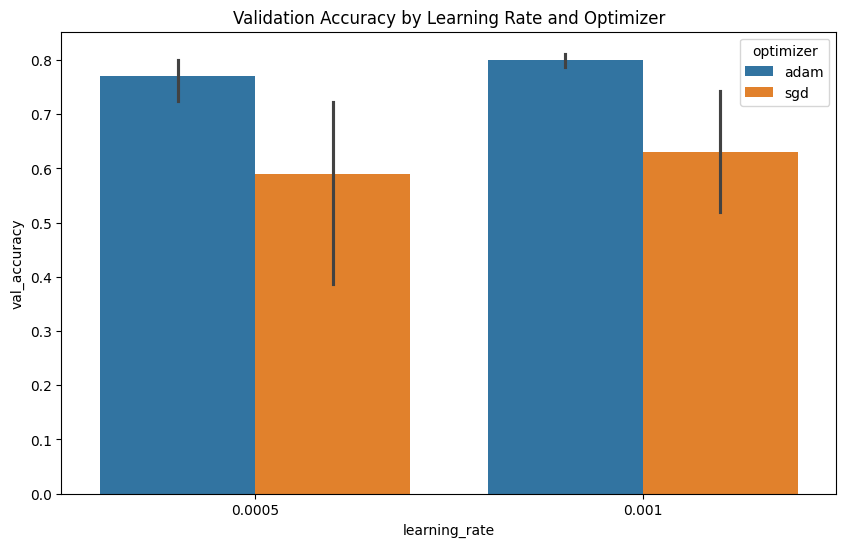

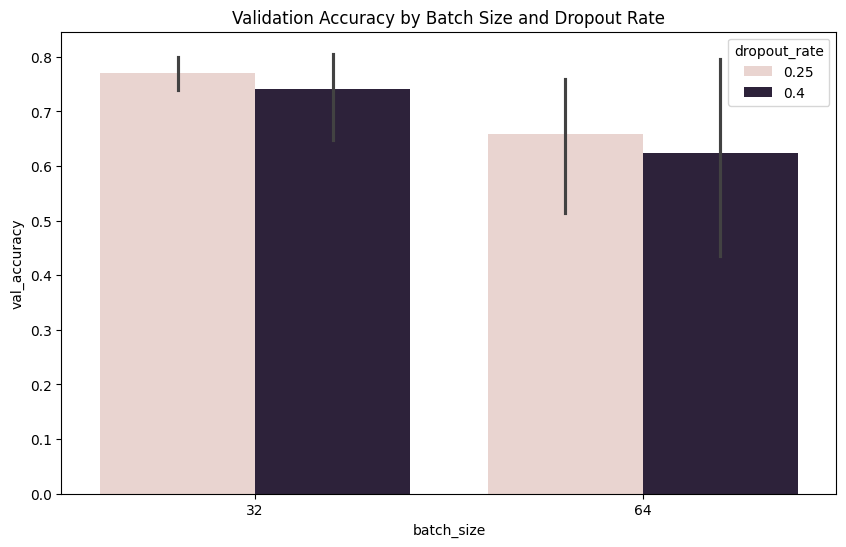

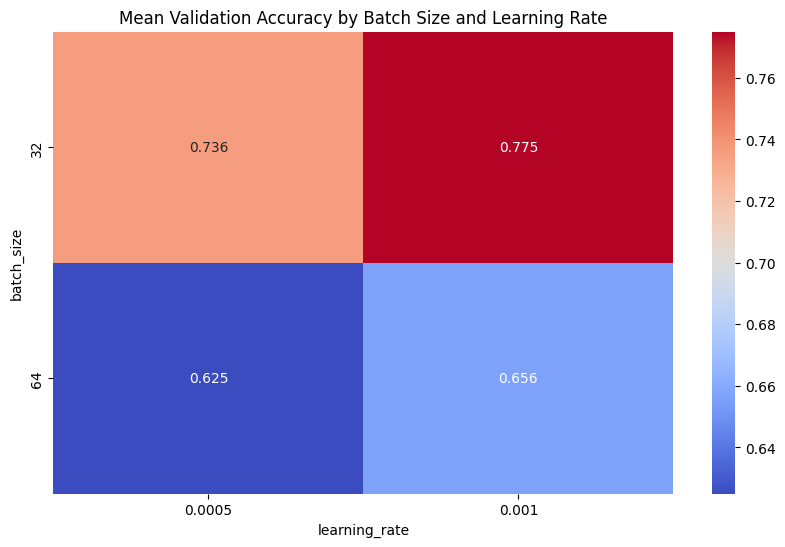

In [21]:
plt.figure(figsize=(10,6))
sns.barplot(x="learning_rate", y="val_accuracy", hue="optimizer", data=results_df)
plt.title("Validation Accuracy by Learning Rate and Optimizer")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x="batch_size", y="val_accuracy", hue="dropout_rate", data=results_df)
plt.title("Validation Accuracy by Batch Size and Dropout Rate")
plt.show()

heatmap_data = results_df.groupby(["batch_size", "learning_rate"])["val_accuracy"].mean().unstack()
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Mean Validation Accuracy by Batch Size and Learning Rate")
plt.show()

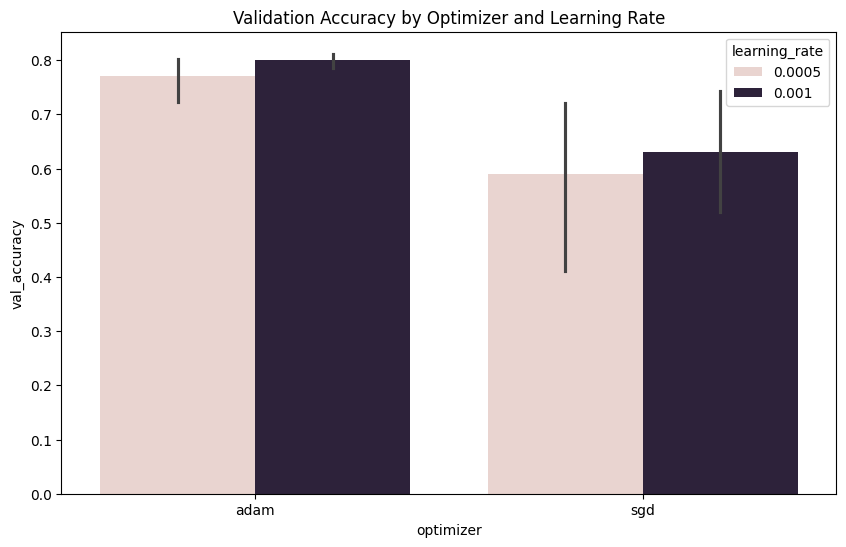

In [22]:
plt.figure(figsize=(10,6))
sns.barplot(x="optimizer", y="val_accuracy", hue="learning_rate", data=results_df)
plt.title("Validation Accuracy by Optimizer and Learning Rate")
plt.show()

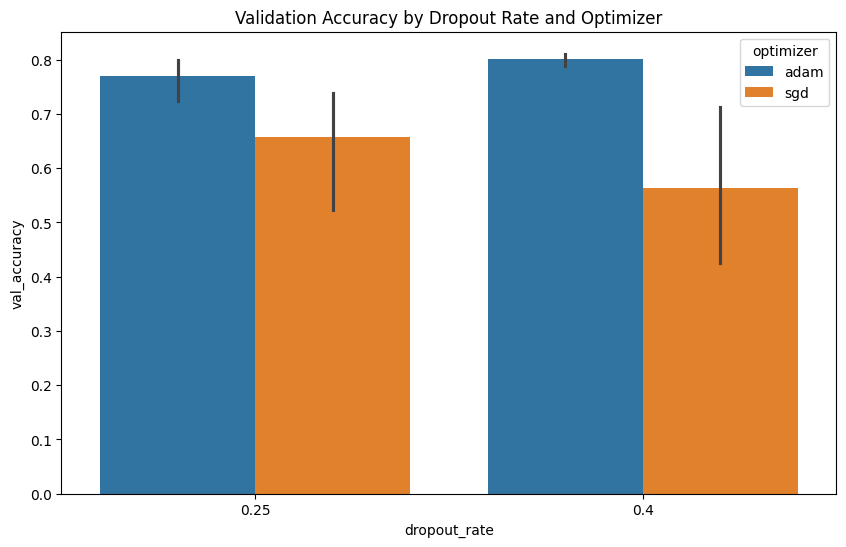

In [23]:
plt.figure(figsize=(10,6))
sns.barplot(x="dropout_rate", y="val_accuracy", hue="optimizer", data=results_df)
plt.title("Validation Accuracy by Dropout Rate and Optimizer")
plt.show()

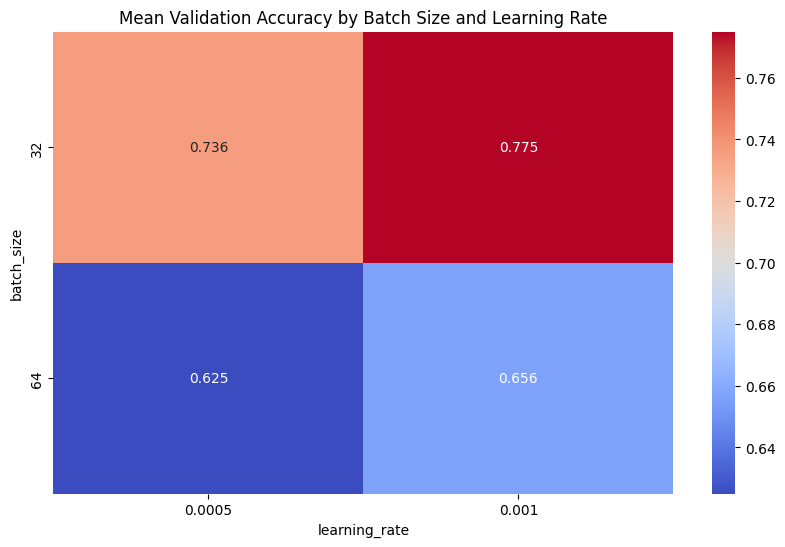

In [24]:
heatmap_data = results_df.groupby(["batch_size", "learning_rate"])["val_accuracy"].mean().unstack()
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Mean Validation Accuracy by Batch Size and Learning Rate")
plt.show()

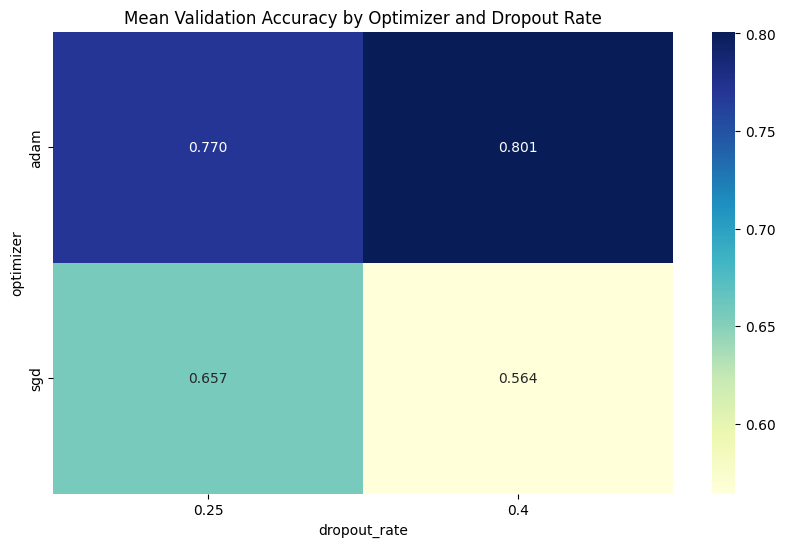

In [25]:
heatmap_data = results_df.groupby(["optimizer", "dropout_rate"])["val_accuracy"].mean().unstack()
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Mean Validation Accuracy by Optimizer and Dropout Rate")
plt.show()

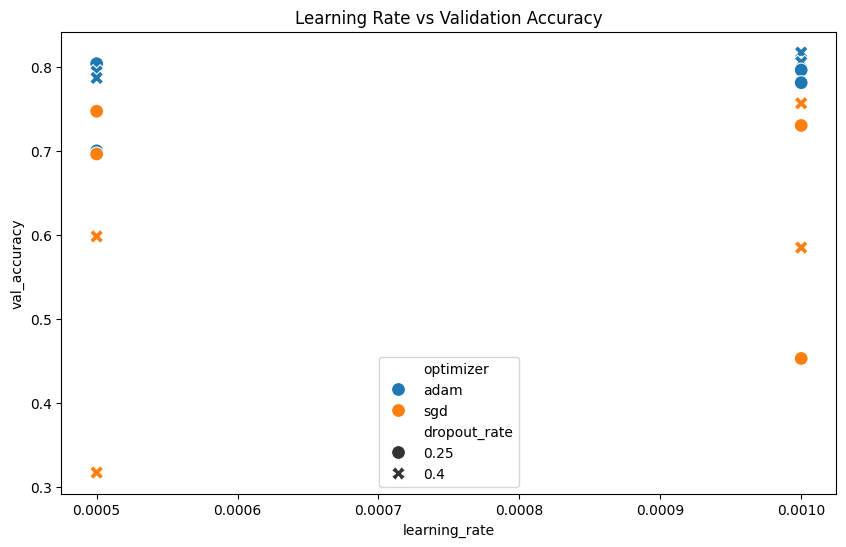

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="learning_rate", y="val_accuracy", hue="optimizer", style="dropout_rate", s=100, data=results_df)
plt.title("Learning Rate vs Validation Accuracy")
plt.show()

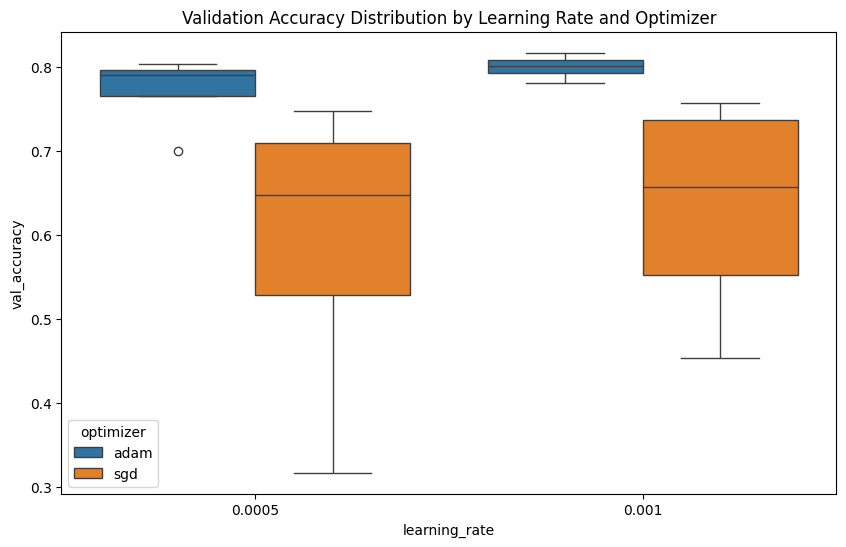

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(x="learning_rate", y="val_accuracy", hue="optimizer", data=results_df)
plt.title("Validation Accuracy Distribution by Learning Rate and Optimizer")
plt.show()


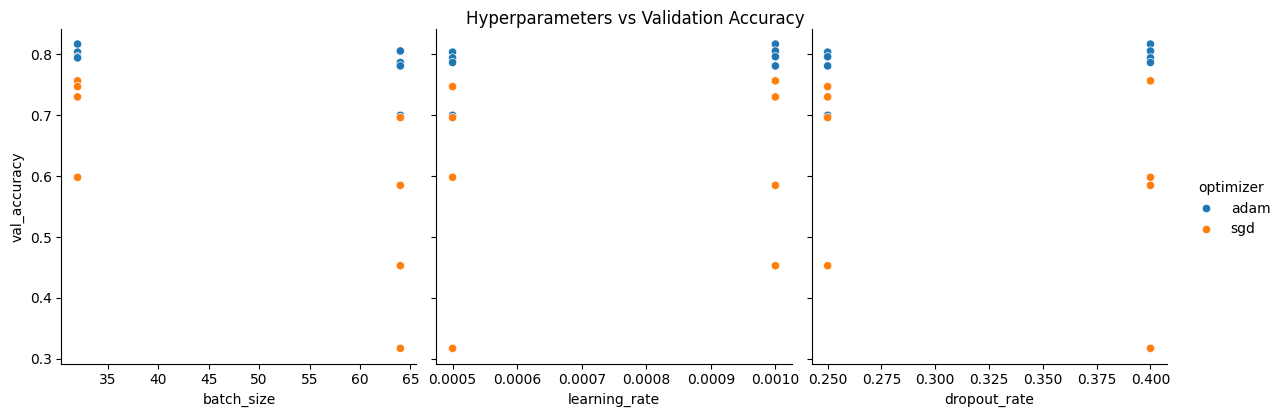

In [29]:
sns.pairplot(results_df, x_vars=["batch_size","learning_rate","dropout_rate"], y_vars=["val_accuracy"], hue="optimizer", height=4, aspect=1)
plt.suptitle("Hyperparameters vs Validation Accuracy", y=1.02)
plt.show()